## Viewing the sat images and the mask ##

This set of code is for viewing the Sat images pre and post and showing the boxes arou

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from PIL import Image
import json
import pathlib

In [1]:
xview_train_img_dir = "c:/data/xview2/train/images"
xview_train_json_dir = "c:/data/xview2/train/labels"

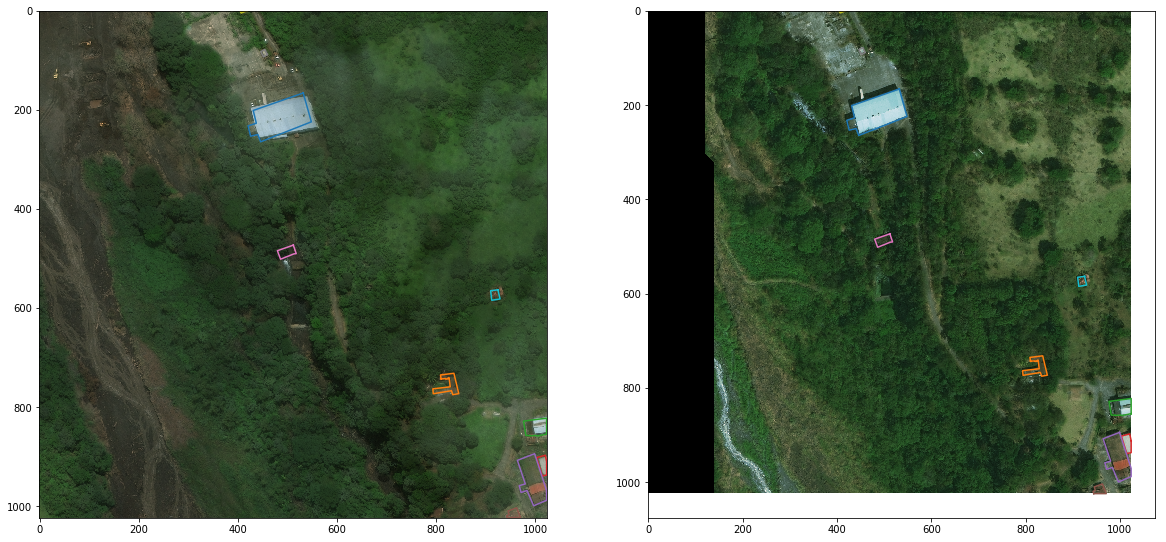

In [58]:
fig, ax = plt.subplots(1,2, figsize=(20,20))

def load_show(ax, img_path, json_path, name):
    image_path=os.path.join(img_path, name+".png")
    json_path = os.path.join(json_path, name+".json")
    j = json.loads(pathlib.Path(json_path).read_text())
    
    im = Image.open(image_path)
    
    #im.show()
    ax.imshow(im)
    
    polygons = extract_polygon(j)
    for p in polygons:
        ax.plot(p[0][0],p[0][1])

    
def plot_polygon(ax, x, y):
    ax.plot(x,y)
    
def extract_polygon(json):
    xy_f = json["features"]["xy"]
    results = []
    for i in xy_f:
        polygon_str = i["wkt"]
        r = decode_polygon(polygon_str)
        results.append((r, i)) if r is not "" else ""
    return results

def decode_polygon(polygon_str):
    if polygon_str.startswith("POLYGON"):
        replace_str = ["POLYGON", "((", "))", ","]
        for rs in replace_str:
            polygon_str = polygon_str.replace(rs,"")
        x_y = polygon_str.strip().split(" ")
        x = list(map(lambda x:float(x), x_y[0::2]))
        y = list(map(lambda x:float(x), x_y[1::2]))
        return [x,y]
    else:
        return ""
            
    
c = decode_polygon("POLYGON ((532.1863714054954 165.9824503000504, 548.6019827848852 224.1613082732768, 446.2458177229872 264.4761185678668, 440.6934785817455 249.7503495372735, 425.9677095499687 253.1300342329752, 420.8981825090282 232.3691139606, 437.5551999358392 227.0581808684396, 431.2786426428399 201.2277335525121, 532.1863714054954 165.9824503000504))")
load_show(ax[0], xview_train_img_dir, xview_train_json_dir, "guatemala-volcano_00000000_post_disaster")
load_show(ax[1], xview_train_img_dir, xview_train_json_dir, "guatemala-volcano_00000000_pre_disaster")
plt.show()